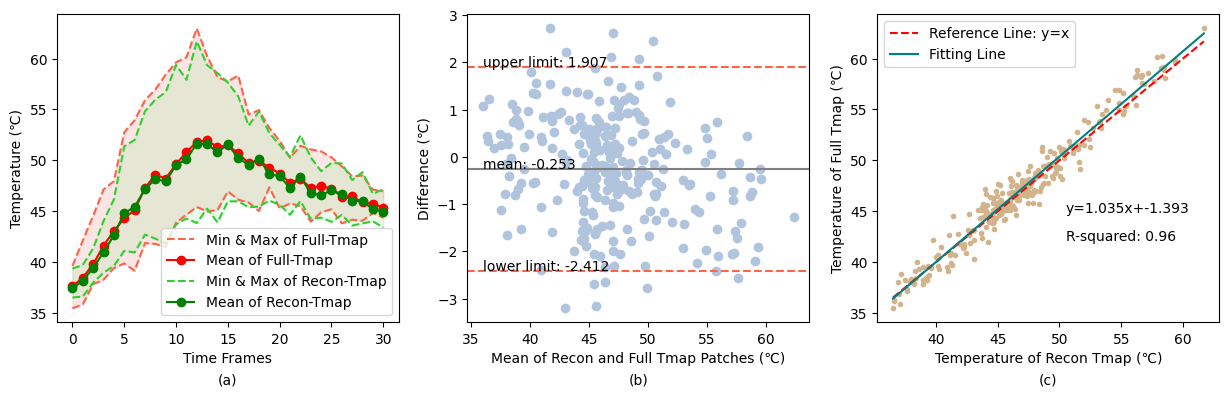

In [1]:
"""Long Sequence Study"""

import os
from fastmrt.utils.metrics import FastmrtMetrics
from fastmrt.utils.vis import draw_bland_altman_fig, draw_linear_regression_fig
import torch
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

datas = {"full_tmap": [], "recon_tmap": []}
resunet_dir = "../logs/RESUNET/38kkh5r3/medias" # phantom 2x
folders = os.listdir(resunet_dir)
long_samples = ["t12007.h5", "t12017.h5", "t14009.h5"]
long_sample_folder = [folder for folder in folders if long_samples[0] in folder]
tmap_height, tmap_width = 96, 96
patch_height, patch_width = 24, 24

for folder in sorted(long_sample_folder):
    full_tmap = np.load(os.path.join(resunet_dir, folder, "full_tmap.npy"))
    recon_tmap = np.load(os.path.join(resunet_dir, folder, "recon_tmap.npy"))
    datas["full_tmap"].append(full_tmap)
    datas["recon_tmap"].append(recon_tmap)

t_center_full = []
t_center_recon = []
for full_tmap, recon_tmap in zip(datas["full_tmap"], datas["recon_tmap"]):
    t_center_full.append(full_tmap[tmap_width // 2 - 1: tmap_width // 2 + 2, tmap_height // 2 - 1: tmap_width // 2 + 2].flatten().reshape([-1, 1]))
    t_center_recon.append(recon_tmap[tmap_width // 2 - 1: tmap_width // 2 + 2, tmap_height // 2 - 1: tmap_width // 2 + 2].flatten().reshape([-1, 1]))

t_center_full = np.concatenate(t_center_full, axis=1)
t_center_recon = np.concatenate(t_center_recon, axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# 绘制散点合并
t = [i for i in range(t_center_full.shape[1])]
t_center_full_upper = t_center_full.max(axis=0)
t_center_full_lower = t_center_full.min(axis=0)
t_center_full_mean = t_center_full.mean(axis=0)
t_center_recon_upper = t_center_recon.max(axis=0)
t_center_recon_lower = t_center_recon.min(axis=0)
t_center_recon_mean = t_center_recon.mean(axis=0)

ax1.plot(t, t_center_full_upper, '--', color="tomato", label="Min & Max of Full-Tmap")
ax1.plot(t, t_center_full_lower, '--', color="tomato")
ax1.plot(t, t_center_full_mean, marker="o", color='red', label="Mean of Full-Tmap")
ax1.fill_between(t, t_center_full_upper, t_center_full_lower, color="lightcoral", alpha=0.2)
ax1.plot(t, t_center_recon_upper, '--', color="limegreen", label="Min & Max of Recon-Tmap")
ax1.plot(t, t_center_recon_lower, '--', color="limegreen")
ax1.plot(t, t_center_recon_mean, marker="o", color='green', label="Mean of Recon-Tmap")
ax1.fill_between(t, t_center_recon_upper, t_center_recon_lower, color="lightgreen", alpha=0.2)
# 添加标签和标题
ax1.set_xlabel("Time Frames")
ax1.set_ylabel("Temperature (℃)")
ax1.legend()
ax1.text(0.5, -0.2, '(a)', ha='center', transform=ax1.transAxes)

ba_mean, ba_error, ba_error_mean, ba_error_std, ba_error_mae = FastmrtMetrics.bland_altman(torch.from_numpy(t_center_recon), torch.from_numpy(t_center_full))
# calculate datas
mean_error = ba_error_mean.cpu().numpy()
loa_upper_limit = ba_error_mean.cpu().numpy() + 1.96 * ba_error_std.cpu().numpy()
loa_lower_limit = ba_error_mean.cpu().numpy() - 1.96 * ba_error_std.cpu().numpy()

# start plot
text_start = ba_mean.cpu().numpy().min()
ax2.scatter(ba_mean.cpu().numpy(), ba_error.cpu().numpy(), color="lightsteelblue")
ax2.axhline(mean_error, color='gray', linestyle='-')
ax2.axhline(loa_upper_limit, color='tomato', linestyle='--')
ax2.axhline(loa_lower_limit, color='tomato', linestyle='--')
ax2.text(text_start, mean_error, "mean: {:.3f}".format(mean_error))
ax2.text(text_start, loa_upper_limit, "upper limit: {:.3f}".format(loa_upper_limit))
ax2.text(text_start, loa_lower_limit, "lower limit: {:.3f}".format(loa_lower_limit))
ax2.set_xlabel("Mean of Recon and Full Tmap Patches (℃)")
ax2.set_ylabel("Difference (℃)")
ax2.text(0.5, -0.2, '(b)', ha='center', transform=ax2.transAxes)

# calculate datas
data_x = t_center_recon.flatten()
data_y = t_center_full.flatten()
[k, b] = np.polyfit(data_x, data_y, deg=1)
slope, intercept, r_value, p_value, std_err = stats.linregress(data_x, data_y)
ref_x = np.linspace(np.min(data_x), np.max(data_x), 10)
ref_y = ref_x
fit_x = ref_x
fit_y = k * fit_x + b

# start plot
ax3.plot(data_x, data_y, '.', color="tan", label="")
ax3.plot(ref_x, ref_y, color="red", linestyle="--", label="Reference Line: y=x")
ax3.plot(fit_x, fit_y, color="teal", linestyle="-", label="Fitting Line")
ax3.text(ref_x[5], ref_y[3], "y={:.3f}x+{:.3f}".format(k, b))
ax3.text(ref_x[5], ref_y[2], f'R-squared: {r_value ** 2:.2f}')
ax3.set_xlabel("Temperature of Recon Tmap (℃)")
ax3.set_ylabel("Temperature of Full Tmap (℃)")
# plt.title("Linear Regression Analysis")
ax3.legend()
ax3.text(0.5, -0.2, '(c)', ha='center', transform=ax3.transAxes)
plt.show()

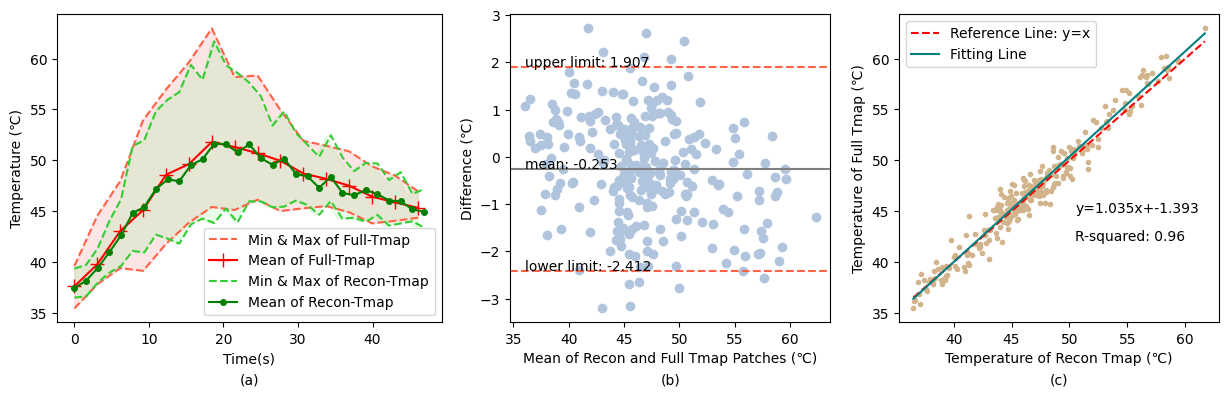

In [17]:
"""Long Sequence Study Version 2"""

import os
from fastmrt.utils.metrics import FastmrtMetrics
from fastmrt.utils.vis import draw_bland_altman_fig, draw_linear_regression_fig
import torch
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

datas = {"full_tmap": [], "recon_tmap": []}
resunet_dir = "../logs/RESUNET/38kkh5r3/medias" # phantom 2x
folders = os.listdir(resunet_dir)
long_samples = ["t12007.h5", "t12017.h5", "t14009.h5"]
long_sample_folder = [folder for folder in folders if long_samples[0] in folder]
tmap_height, tmap_width = 96, 96
patch_height, patch_width = 24, 24

for folder in sorted(long_sample_folder):
    full_tmap = np.load(os.path.join(resunet_dir, folder, "full_tmap.npy"))
    recon_tmap = np.load(os.path.join(resunet_dir, folder, "recon_tmap.npy"))
    datas["full_tmap"].append(full_tmap)
    datas["recon_tmap"].append(recon_tmap)

t_center_full = []
t_center_recon = []
for full_tmap, recon_tmap in zip(datas["full_tmap"], datas["recon_tmap"]):
    t_center_full.append(full_tmap[tmap_width // 2 - 1: tmap_width // 2 + 2, tmap_height // 2 - 1: tmap_width // 2 + 2].flatten().reshape([-1, 1]))
    t_center_recon.append(recon_tmap[tmap_width // 2 - 1: tmap_width // 2 + 2, tmap_height // 2 - 1: tmap_width // 2 + 2].flatten().reshape([-1, 1]))

t_center_full = np.concatenate(t_center_full, axis=1)
t_center_recon = np.concatenate(t_center_recon, axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={'width_ratios': [1.2, 1, 1]})

# 绘制散点合并
sample_t = 96 * 0.016
model_t = 0.0277
full_t = [i * sample_t for i in range(t_center_full.shape[1])]
recon_t = [i * (sample_t + model_t) for i in range(t_center_full.shape[1])]
t_center_full_upper = t_center_full.max(axis=0)
t_center_full_lower = t_center_full.min(axis=0)
t_center_full_mean = t_center_full.mean(axis=0)
t_center_recon_upper = t_center_recon.max(axis=0)
t_center_recon_lower = t_center_recon.min(axis=0)
t_center_recon_mean = t_center_recon.mean(axis=0)

ax1.plot(full_t[::2], t_center_full_upper[::2], '--', color="tomato", label="Min & Max of Full-Tmap")
ax1.plot(full_t[::2], t_center_full_lower[::2], '--', color="tomato")
ax1.plot(full_t[::2], t_center_full_mean[::2], marker="+", color='red', markersize=10, label="Mean of Full-Tmap")
ax1.fill_between(full_t[::2], t_center_full_upper[::2], t_center_full_lower[::2], color="lightcoral", alpha=0.2)
ax1.plot(recon_t, t_center_recon_upper, '--', color="limegreen", label="Min & Max of Recon-Tmap")
ax1.plot(recon_t, t_center_recon_lower, '--', color="limegreen")
ax1.plot(recon_t, t_center_recon_mean, marker="o", color='green', markersize=4, label="Mean of Recon-Tmap")
ax1.fill_between(t, t_center_recon_upper, t_center_recon_lower, color="lightgreen", alpha=0.2)
# 添加标签和标题
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Temperature (℃)")
ax1.legend()
ax1.text(0.5, -0.2, '(a)', ha='center', transform=ax1.transAxes)

ba_mean, ba_error, ba_error_mean, ba_error_std, ba_error_mae = FastmrtMetrics.bland_altman(torch.from_numpy(t_center_recon), torch.from_numpy(t_center_full))
# calculate datas
mean_error = ba_error_mean.cpu().numpy()
loa_upper_limit = ba_error_mean.cpu().numpy() + 1.96 * ba_error_std.cpu().numpy()
loa_lower_limit = ba_error_mean.cpu().numpy() - 1.96 * ba_error_std.cpu().numpy()

# start plot
text_start = ba_mean.cpu().numpy().min()
ax2.scatter(ba_mean.cpu().numpy(), ba_error.cpu().numpy(), color="lightsteelblue")
ax2.axhline(mean_error, color='gray', linestyle='-')
ax2.axhline(loa_upper_limit, color='tomato', linestyle='--')
ax2.axhline(loa_lower_limit, color='tomato', linestyle='--')
ax2.text(text_start, mean_error, "mean: {:.3f}".format(mean_error))
ax2.text(text_start, loa_upper_limit, "upper limit: {:.3f}".format(loa_upper_limit))
ax2.text(text_start, loa_lower_limit, "lower limit: {:.3f}".format(loa_lower_limit))
ax2.set_xlabel("Mean of Recon and Full Tmap Patches (℃)")
ax2.set_ylabel("Difference (℃)")
ax2.text(0.5, -0.2, '(b)', ha='center', transform=ax2.transAxes)

# calculate datas
data_x = t_center_recon.flatten()
data_y = t_center_full.flatten()
[k, b] = np.polyfit(data_x, data_y, deg=1)
slope, intercept, r_value, p_value, std_err = stats.linregress(data_x, data_y)
ref_x = np.linspace(np.min(data_x), np.max(data_x), 10)
ref_y = ref_x
fit_x = ref_x
fit_y = k * fit_x + b

# start plot
ax3.plot(data_x, data_y, '.', color="tan", label="")
ax3.plot(ref_x, ref_y, color="red", linestyle="--", label="Reference Line: y=x")
ax3.plot(fit_x, fit_y, color="teal", linestyle="-", label="Fitting Line")
ax3.text(ref_x[5], ref_y[3], "y={:.3f}x+{:.3f}".format(k, b))
ax3.text(ref_x[5], ref_y[2], f'R-squared: {r_value ** 2:.2f}')
ax3.set_xlabel("Temperature of Recon Tmap (℃)")
ax3.set_ylabel("Temperature of Full Tmap (℃)")
# plt.title("Linear Regression Analysis")
ax3.legend()
ax3.text(0.5, -0.2, '(c)', ha='center', transform=ax3.transAxes)
plt.show()

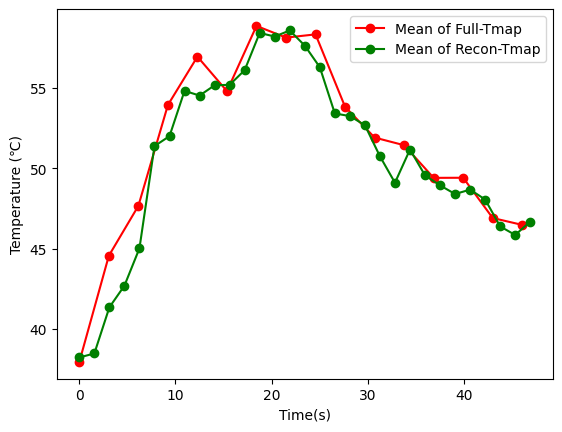

In [9]:
"""Time Resolution Enhancement Experiment"""

import os
from fastmrt.utils.metrics import FastmrtMetrics
from fastmrt.utils.vis import draw_bland_altman_fig, draw_linear_regression_fig
import torch
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

datas = {"full_tmap": [], "recon_tmap": []}
resunet_dir = "../logs/RESUNET/38kkh5r3/medias" # phantom 2x
folders = os.listdir(resunet_dir)
long_samples = ["t12007.h5", "t12017.h5", "t14009.h5"]
long_sample_folder = [folder for folder in folders if long_samples[0] in folder]
tmap_height, tmap_width = 96, 96
patch_height, patch_width = 24, 24

for folder in sorted(long_sample_folder):
    full_tmap = np.load(os.path.join(resunet_dir, folder, "full_tmap.npy"))
    recon_tmap = np.load(os.path.join(resunet_dir, folder, "recon_tmap.npy"))
    datas["full_tmap"].append(full_tmap)
    datas["recon_tmap"].append(recon_tmap)

t_center_full = []
t_center_recon = []
for full_tmap, recon_tmap in zip(datas["full_tmap"], datas["recon_tmap"]):
    t_center_full.append(full_tmap[tmap_width // 2, tmap_height // 2].flatten().reshape([-1, 1]))
    t_center_recon.append(recon_tmap[tmap_width // 2, tmap_height // 2].flatten().reshape([-1, 1]))

t_center_full = np.concatenate(t_center_full, axis=1)
t_center_recon = np.concatenate(t_center_recon, axis=1)


# 绘制散点合并
sample_t = 96 * 0.016
recon_t = 0.0277
t = [i * sample_t for i in range(t_center_full.shape[1])]
t_center_full_mean = t_center_full.mean(axis=0)
t_center_recon_mean = t_center_recon.mean(axis=0)

plt.plot(t[::2], t_center_full_mean[::2], marker="o", color='red', label="Mean of Full-Tmap")
plt.plot([_t + i * recon_t for i, _t in enumerate(t)], t_center_recon_mean, marker="o", color='green', label="Mean of Recon-Tmap")
# 添加标签和标题
plt.xlabel("Time(s)")
plt.ylabel("Temperature (℃)")
plt.legend()


plt.show()

../logs/RESUNET/38kkh5r3/medias
['FastMRT Dataset V5.0_phantom_test_t12007.h5_f01s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f02s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f03s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f04s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f05s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f06s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f07s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f08s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f09s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f10s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f11s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f12s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f13s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f14s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f15s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f16s0c0', 'FastMRT Dataset V5.0_phantom_test_t12007.h5_f17s0c0', 'FastMRT Dataset V5.0_phantom_te

Text(0.5, -0.2, '(c)')

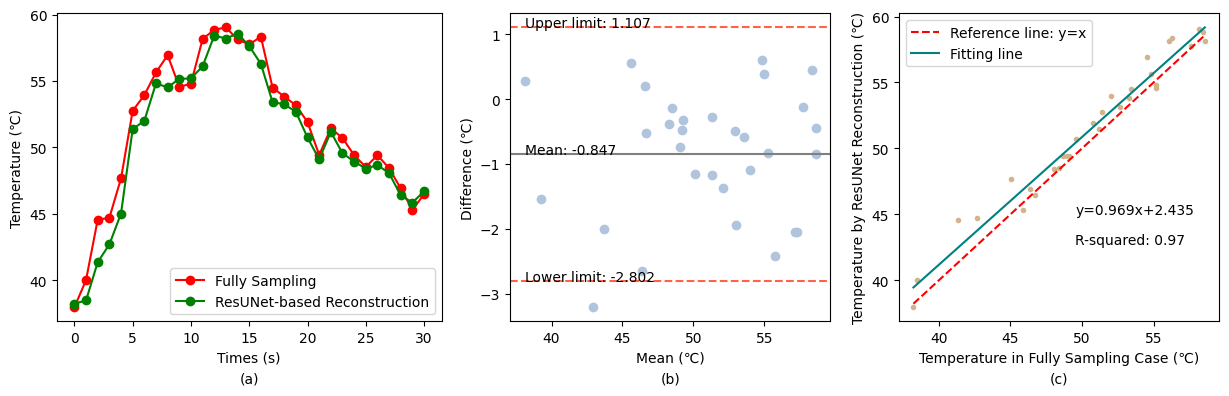

In [7]:
"""Long Sequence Study for ISMRM"""
import os
from fastmrt.utils.metrics import FastmrtMetrics
from fastmrt.utils.vis import draw_bland_altman_fig, draw_linear_regression_fig
import torch
import scipy.stats as stats

datas = {"full_tmap": [], "recon_tmap": []}
resunet_dir = "../logs/RESUNET/38kkh5r3/medias" # phantom 2x
folders = os.listdir(resunet_dir)
long_samples = ["t12007.h5", "t12017.h5", "t14009.h5"]
long_sample_folder = [folder for folder in folders if long_samples[0] in folder]

for folder in sorted(long_sample_folder):
    full_tmap = np.load(os.path.join(resunet_dir, folder, "full_tmap.npy"))
    recon_tmap = np.load(os.path.join(resunet_dir, folder, "recon_tmap.npy"))
    datas["full_tmap"].append(full_tmap)
    datas["recon_tmap"].append(recon_tmap)

t_center_full = []
t_center_recon = []
for full_tmap, recon_tmap in zip(datas["full_tmap"], datas["recon_tmap"]):
    t_center_full.append(full_tmap[tmap_width // 2, tmap_height // 2].flatten().reshape([-1, 1]))
    t_center_recon.append(recon_tmap[tmap_width // 2, tmap_height // 2].flatten().reshape([-1, 1]))

t_center_full = np.concatenate(t_center_full, axis=1)
t_center_recon = np.concatenate(t_center_recon, axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={'width_ratios': [1.2, 1, 1]})

# 绘制散点合并
t = [i for i in range(t_center_full.shape[1])]
t_center_full_mean = t_center_full.mean(axis=0)
t_center_recon_mean = t_center_recon.mean(axis=0)

ax1.plot(t, t_center_full_mean, marker="o", color='red', label="Fully Sampling")
ax1.plot(t, t_center_recon_mean, marker="o", color='green', label="ResUNet-based Reconstruction")
# 添加标签和标题
ax1.set_xlabel("Times (s)")
ax1.set_ylabel("Temperature (℃)")
# plt.title("Temperature Range in Central Area of a Long Sequence Sample")
ax1.legend()
ax1.text(0.5, -0.2, '(a)', ha='center', transform=ax1.transAxes)

ba_mean, ba_error, ba_error_mean, ba_error_std, ba_error_mae = FastmrtMetrics.bland_altman(torch.from_numpy(t_center_recon), torch.from_numpy(t_center_full))
# calculate datas
mean_error = ba_error_mean.cpu().numpy()
loa_upper_limit = ba_error_mean.cpu().numpy() + 1.96 * ba_error_std.cpu().numpy()
loa_lower_limit = ba_error_mean.cpu().numpy() - 1.96 * ba_error_std.cpu().numpy()

# start plot
text_start = ba_mean.cpu().numpy().min()
ax2.scatter(ba_mean.cpu().numpy(), ba_error.cpu().numpy(), color="lightsteelblue")
ax2.axhline(mean_error, color='gray', linestyle='-')
ax2.axhline(loa_upper_limit, color='tomato', linestyle='--')
ax2.axhline(loa_lower_limit, color='tomato', linestyle='--')
ax2.text(text_start, mean_error, "Mean: {:.3f}".format(mean_error))
ax2.text(text_start, loa_upper_limit, "Upper limit: {:.3f}".format(loa_upper_limit))
ax2.text(text_start, loa_lower_limit, "Lower limit: {:.3f}".format(loa_lower_limit))
ax2.set_xlabel("Mean (℃)")
ax2.set_ylabel("Difference (℃)")
ax2.text(0.5, -0.2, '(b)', ha='center', transform=ax2.transAxes)

# calculate datas
data_x = t_center_recon.flatten()
data_y = t_center_full.flatten()
[k, b] = np.polyfit(data_x, data_y, deg=1)
slope, intercept, r_value, p_value, std_err = stats.linregress(data_x, data_y)
ref_x = np.linspace(np.min(data_x), np.max(data_x), 10)
ref_y = ref_x
fit_x = ref_x
fit_y = k * fit_x + b

# start plot
ax3.plot(data_x, data_y, '.', color="tan", label="")
ax3.plot(ref_x, ref_y, color="red", linestyle="--", label="Reference line: y=x")
ax3.plot(fit_x, fit_y, color="teal", linestyle="-", label="Fitting line")
ax3.text(ref_x[5], ref_y[3], "y={:.3f}x+{:.3f}".format(k, b))
ax3.text(ref_x[5], ref_y[2], f'R-squared: {r_value ** 2:.2f}')
ax3.set_xlabel("Temperature in Fully Sampling Case (℃)")
ax3.set_ylabel("Temperature by ResUNet Reconstruction (℃)")
# plt.title("Linear Regression Analysis")
ax3.legend()
ax3.text(0.5, -0.2, '(c)', ha='center', transform=ax3.transAxes)